# 03. BoF con Búsqueda de Hiperparámetros (Grid Search) y Group CV

Este notebook implementa el pipeline completo de Bag of Features (BoF) usando la metodología más robusta para este dataset: **Validación Cruzada por Grupos (Group K-Fold CV)**.

Además, incluye un bucle de **Búsqueda de Hiperparámetros (Grid Search)** para encontrar automáticamente la mejor combinación de:
1.  `K_CLUSTERS`: El número de "palabras" en el diccionario K-Means.
2.  `SVM_C`: El parámetro de regularización del clasificador SVM.

## Pipeline
1.  Cargar y Redimensionar Datos.
2.  **Bucle de Búsqueda (Grid Search):**
    * Para cada combinación de hiperparámetros (`K` y `C`):
    * Ejecutar una **Validación Cruzada (CV) de 5 folds** completa.
    * Guardar la precisión promedio de esa CV.
3.  **Resultados:** Comparar todos los promedios y seleccionar la mejor combinación.
4.  **Evaluación Final:** Entrenar y evaluar el modelo una última vez con los mejores hiperparámetros para generar la matriz de confusión final.

In [1]:
# Instalación de dependencias (descomentar si es necesario)
# !pip install "numpy>=1.24.0,<2.0.0" scikit-learn pandas tqdm matplotlib tabulate

# Configuración para ejecución local
from pathlib import Path

# Directorio raíz del proyecto (local)
ROOT_DIR = Path.cwd()

# Estructura unificada de directorios
DATA_DIR = ROOT_DIR / 'data'
RESULTS_DIR = ROOT_DIR / 'results'

BOF_DATA_DIR = DATA_DIR / 'bof_features'  # Lee features del notebook 02
BOF_RESULTS_DIR = RESULTS_DIR / 'bof_svm'  # Guarda resultados aquí

# Crear directorio de resultados
BOF_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Directorio raíz: {ROOT_DIR}")
print(f"✅ Directorio BoF Features (entrada): {BOF_DATA_DIR}")
print(f"   Verificando existencia: {BOF_DATA_DIR.exists()}")
print(f"✅ Directorio BoF Results (salida): {BOF_RESULTS_DIR}")

✅ Directorio raíz: /Users/manueljurado/Downloads/datos_BCI
✅ Directorio BoF Features (entrada): /Users/manueljurado/Downloads/datos_BCI/data/bof_features
   Verificando existencia: True
✅ Directorio BoF Results (salida): /Users/manueljurado/Downloads/datos_BCI/results/bof_svm


In [2]:
# Celda 2: Importar librerías
import numpy as np
import json
import pandas as pd
from pathlib import Path
import time

# Model Selection y Métricas
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, classification_report
)

# Clustering y Clasificación
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Utilitarios
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Librerías importadas.")

Librerías importadas.


## 1. Carga y Preparación de Datos
Cargamos los archivos generados por el notebook `02_Wavelet_Analysis` y los redimensionamos al formato BoF: `(trials, channels, descriptors)`.

In [11]:
# Celda 3: Carga de datos y Redimensionamiento
# Usa BOF_DATA_DIR definido en la celda 1

try:
    print(f"Cargando datos desde: {BOF_DATA_DIR}")
    
    X_features = np.load(BOF_DATA_DIR / "X_bof_features.npy")
    y_labels = np.load(BOF_DATA_DIR / "y_labels.npy")
    subject_groups = np.load(BOF_DATA_DIR / "trial_to_subject.npy")
    
    with open(BOF_DATA_DIR / "bof_metadata.json", 'r') as f:
        metadata = json.load(f)

    # Parámetros para redimensionar
    N_TRIALS = metadata['n_trials']
    N_CHANNELS = metadata['n_channels']
    N_DESCRIPTORS = X_features.shape[1] // N_CHANNELS

    # Redimensionar a (trials, channels, descriptors)
    X_reshaped = X_features.reshape(N_TRIALS, N_DESCRIPTORS, N_CHANNELS).transpose(0, 2, 1)

    print(f"✅ Datos cargados y redimensionados: {X_reshaped.shape}")
    print(f"   - Grupos de sujetos: {subject_groups.shape}")
    print(f"   - Labels: {np.bincount(y_labels)}")
    print(f"   - Sujetos únicos: {len(np.unique(subject_groups))}")

except FileNotFoundError as e:
    print(f"❌ ERROR: No se encontró el archivo. {e}")
    print(f"   Verifica que el notebook 02_Wavelet_Analysis.ipynb se haya ejecutado primero.")
    print(f"   Los archivos deben estar en: {BOF_DATA_DIR}")
    X_reshaped = np.array([])  # Evitar errores si falla la carga

Cargando datos desde: /Users/manueljurado/Downloads/datos_BCI/data/bof_features
✅ Datos cargados y redimensionados: (880, 64, 9)
   - Grupos de sujetos: (880,)
   - Labels: [442 438]
   - Sujetos únicos: 20


## 2. Función de Codificación BoF
Función auxiliar para crear los histogramas.

In [12]:
# Celda 4: Función para crear histogramas BoF
def create_bof_histograms(data, kmeans_model):
    """Codifica los descriptores (canales) en histogramas BoF usando un Codebook."""
    n_trials = data.shape[0]
    n_clusters = kmeans_model.n_clusters
    bof_histograms = np.zeros((n_trials, n_clusters), dtype=np.float32)

    for i in range(n_trials):
        trial_descriptors = data[i] # (n_channels, n_descriptors)
        cluster_labels = kmeans_model.predict(trial_descriptors)

        # Contar ocurrencias (histograma)
        hist, _ = np.histogram(cluster_labels, bins=range(n_clusters + 1))

        # Normalizar L1
        hist_norm = hist.astype(np.float32)
        total_counts = np.sum(hist_norm)
        if total_counts > 0:
            hist_norm /= total_counts

        bof_histograms[i] = hist_norm

    return bof_histograms

## 3. Búsqueda de Hiperparámetros (Grid Search + Group K-Fold CV)

Aquí está el script automático. Definimos una "cuadrícula" (grid) de hiperparámetros que queremos probar. El script iterará sobre todas las combinaciones y ejecutará una Validación Cruzada completa para cada una, guardando el promedio de todas las métricas (Accuracy, Precision, Recall, F1).

**Advertencia:** Esto puede tardar bastante.

In [13]:
# Celda 5: Bucle de Búsqueda de Hiperparámetros

# --- 1. Definir la Cuadrícula de Búsqueda ---
param_grid = {
    'k_clusters': [50, 100, 150],  # Valores de K para K-Means
    'svm_c': [1.0, 10.0, 50.0]      # Valores de C para el SVM
}
N_SPLITS = 5
RANDOM_STATE = 42

# --- 2. Preparar el Bucle ---
grid_search_results = []
gkf = GroupKFold(n_splits=N_SPLITS)

print(f"Iniciando Grid Search para {len(param_grid['k_clusters']) * len(param_grid['svm_c'])} combinaciones...")
total_start_time = time.time()

# Bucle externo: Itera sobre los hiperparámetros
for k in param_grid['k_clusters']:
    for c in param_grid['svm_c']:

        start_time = time.time()
        print(f"\nProbando combinación: K={k}, C={c}")

        # Listas para guardar las métricas de cada fold
        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []
        fold_f1_scores = []

        # Bucle interno: La Validación Cruzada (K-Fold)
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_reshaped, y_labels, groups=subject_groups)):

            X_train_trials, X_test_trials = X_reshaped[train_idx], X_reshaped[test_idx]
            y_train, y_test = y_labels[train_idx], y_labels[test_idx]

            # Entrenar K-Means (Codebook)
            n_tr, n_ch, n_desc = X_train_trials.shape
            descriptors_pool = X_train_trials.reshape(n_tr * n_ch, n_desc)
            kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, batch_size=256)
            kmeans.fit(descriptors_pool)

            # Codificar Histogramas (Train y Test)
            X_train_hist = create_bof_histograms(X_train_trials, kmeans)
            X_test_hist = create_bof_histograms(X_test_trials, kmeans)

            # Estandarizar
            scaler = StandardScaler()
            X_train_hist_scaled = scaler.fit_transform(X_train_hist)
            X_test_hist_scaled = scaler.transform(X_test_hist)

            # Entrenar y Evaluar SVM
            svm_classifier = SVC(kernel='rbf', C=c, random_state=RANDOM_STATE)
            svm_classifier.fit(X_train_hist_scaled, y_train)
            y_pred = svm_classifier.predict(X_test_hist_scaled)

            # --- CALCULAR TODAS LAS MÉTRICAS ---
            # 'zero_division=0' evita warnings si una clase no es predicha (común en folds difíciles)
            fold_accuracies.append(accuracy_score(y_test, y_pred))
            fold_precisions.append(precision_score(y_test, y_pred, zero_division=0))
            fold_recalls.append(recall_score(y_test, y_pred, zero_division=0))
            fold_f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

        # Fin del K-Fold: Calcular promedio para esta combinación
        mean_acc = np.mean(fold_accuracies)
        mean_prec = np.mean(fold_precisions)
        mean_rec = np.mean(fold_recalls)
        mean_f1 = np.mean(fold_f1_scores)
        elapsed = time.time() - start_time

        # Reportar las métricas clave
        print(f"  -> Resultado: Acc={mean_acc:.4f}, Precision={mean_prec:.4f}, Recall={mean_rec:.4f}, F1={mean_f1:.4f}")

        grid_search_results.append({
            'k_clusters': k,
            'svm_c': c,
            'mean_accuracy': mean_acc,
            'mean_precision': mean_prec,
            'mean_recall': mean_rec,
            'mean_f1': mean_f1
        })

print(f"\n--- Búsqueda de Hiperparámetros Completada ---")
print(f"Tiempo total: {(time.time() - total_start_time) / 60:.2f} minutos")

Iniciando Grid Search para 9 combinaciones...

Probando combinación: K=50, C=1.0
  -> Resultado: Acc=0.4955, Precision=0.4985, Recall=0.5440, F1=0.5164

Probando combinación: K=50, C=10.0
  -> Resultado: Acc=0.5284, Precision=0.5237, Recall=0.5712, F1=0.5451

Probando combinación: K=50, C=50.0
  -> Resultado: Acc=0.5250, Precision=0.5269, Recall=0.5618, F1=0.5370

Probando combinación: K=100, C=1.0
  -> Resultado: Acc=0.5102, Precision=0.5136, Recall=0.5441, F1=0.5231

Probando combinación: K=100, C=10.0
  -> Resultado: Acc=0.5102, Precision=0.5129, Recall=0.5300, F1=0.5168

Probando combinación: K=100, C=50.0
  -> Resultado: Acc=0.5023, Precision=0.5039, Recall=0.5318, F1=0.5146

Probando combinación: K=150, C=1.0
  -> Resultado: Acc=0.4920, Precision=0.4943, Recall=0.5010, F1=0.4871

Probando combinación: K=150, C=10.0
  -> Resultado: Acc=0.4932, Precision=0.4976, Recall=0.5095, F1=0.4987

Probando combinación: K=150, C=50.0
  -> Resultado: Acc=0.4909, Precision=0.4913, Recall=0.5212

## 4. Resultados del Ajuste (Grid Search)

Ahora vemos los resultados de todas las combinaciones y elegimos la ganadora.

In [14]:
# Celda 6: Mostrar resultados y encontrar el mejor
results_df = pd.DataFrame(grid_search_results)

# --- CORRECCIÓN: Ordenar por F1-score, que es la métrica más robusta ---
results_df = results_df.sort_values(by='mean_f1', ascending=False)

print("Resultados del Grid Search (ordenados por F1-score):")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# Encontrar los mejores parámetros
best_params = results_df.iloc[0].to_dict()

print("\n--- 🏆 Mejor Combinación Encontrada (basada en F1-Score) ---")
print(f"  K-Clusters: {int(best_params['k_clusters'])}")
print(f"  SVM C: {best_params['svm_c']}")
print(f"  Precisión Promedio (F1): {best_params['mean_f1']:.4f}")
print(f"  (Accuracy de esta combinación: {best_params['mean_accuracy']:.4f})")

Resultados del Grid Search (ordenados por F1-score):
|   k_clusters |   svm_c |   mean_accuracy |   mean_precision |   mean_recall |   mean_f1 |
|-------------:|--------:|----------------:|-----------------:|--------------:|----------:|
|      50.0000 | 10.0000 |          0.5284 |           0.5237 |        0.5712 |    0.5451 |
|      50.0000 | 50.0000 |          0.5250 |           0.5269 |        0.5618 |    0.5370 |
|     100.0000 |  1.0000 |          0.5102 |           0.5136 |        0.5441 |    0.5231 |
|     100.0000 | 10.0000 |          0.5102 |           0.5129 |        0.5300 |    0.5168 |
|      50.0000 |  1.0000 |          0.4955 |           0.4985 |        0.5440 |    0.5164 |
|     100.0000 | 50.0000 |          0.5023 |           0.5039 |        0.5318 |    0.5146 |
|     150.0000 | 50.0000 |          0.4909 |           0.4913 |        0.5212 |    0.5019 |
|     150.0000 | 10.0000 |          0.4932 |           0.4976 |        0.5095 |    0.4987 |
|     150.0000 |  1.0000 | 

## 5. Evaluación Final (con los Mejores Hiperparámetros)

Ahora que el "Grid Search" nos dijo cuáles son los mejores hiperparámetros (basados en F1-Score), corremos la Validación Cruzada por Grupos (Group K-Fold CV) una última vez usando solo esa combinación ganadora.

Esto lo hacemos para obtener las métricas finales detalladas y el **Reporte de Clasificación**.

In [15]:
# Celda 7: Ejecución Final y Definitiva
print(f"Ejecutando CV final con los mejores parámetros: K={int(best_params['k_clusters'])}, C={best_params['svm_c']}")

# --- Parámetros Ganadores ---
BEST_K = int(best_params['k_clusters'])
BEST_C = best_params['svm_c']
# -----------------------------

# Listas para guardar las predicciones de *todos* los folds de prueba
all_y_true = []
all_y_pred = []

gkf_final = GroupKFold(n_splits=N_SPLITS)
svm_final = SVC(kernel='rbf', C=BEST_C, probability=True, random_state=RANDOM_STATE)

for fold, (train_idx, test_idx) in enumerate(tqdm(gkf_final.split(X_reshaped, y_labels, groups=subject_groups), total=N_SPLITS, desc="Procesando Fold Final")):

    X_train_trials, X_test_trials = X_reshaped[train_idx], X_reshaped[test_idx]
    y_train, y_test = y_labels[train_idx], y_labels[test_idx]

    # Entrenar K-Means (Codebook)
    n_tr, n_ch, n_desc = X_train_trials.shape
    descriptors_pool = X_train_trials.reshape(n_tr * n_ch, n_desc)
    kmeans_final = MiniBatchKMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=10, batch_size=256)
    kmeans_final.fit(descriptors_pool)

    # Codificar Histogramas (Train y Test)
    X_train_hist = create_bof_histograms(X_train_trials, kmeans_final)
    X_test_hist = create_bof_histograms(X_test_trials, kmeans_final)

    # Estandarizar
    scaler_final = StandardScaler()
    X_train_hist_scaled = scaler_final.fit_transform(X_train_hist)
    X_test_hist_scaled = scaler_final.transform(X_test_hist)

    # Entrenar y Evaluar SVM
    svm_final.fit(X_train_hist_scaled, y_train)
    y_pred = svm_final.predict(X_test_hist_scaled)

    # Guardar resultados para la matriz de confusión final
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("\n--- Resultados Finales (Modelo Optimizado) ---")
# Ahora calculamos las métricas agregadas sobre todas las predicciones
final_acc = accuracy_score(all_y_true, all_y_pred)
final_prec = precision_score(all_y_true, all_y_pred, zero_division=0)
final_rec = recall_score(all_y_true, all_y_pred, zero_division=0)
final_f1 = f1_score(all_y_true, all_y_pred, zero_division=0)

print(f"Métricas Agregadas (sobre todas las {len(all_y_true)} predicciones de prueba):")
print(f"  - Accuracy: {final_acc:.4f}")
print(f"  - Precision: {final_prec:.4f}")
print(f"  - Recall: {final_rec:.4f}")
print(f"  - F1-Score: {final_f1:.4f}")

Ejecutando CV final con los mejores parámetros: K=50, C=10.0


Procesando Fold Final: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


--- Resultados Finales (Modelo Optimizado) ---
Métricas Agregadas (sobre todas las 880 predicciones de prueba):
  - Accuracy: 0.5284
  - Precision: 0.5241
  - Recall: 0.5708
  - F1-Score: 0.5464


--- Reporte de Clasificación Detallado (Agregado) ---
              precision    recall  f1-score   support

        left       0.53      0.49      0.51       442
       right       0.52      0.57      0.55       438

    accuracy                           0.53       880
   macro avg       0.53      0.53      0.53       880
weighted avg       0.53      0.53      0.53       880


--- Matriz de Confusión (Agregada) ---


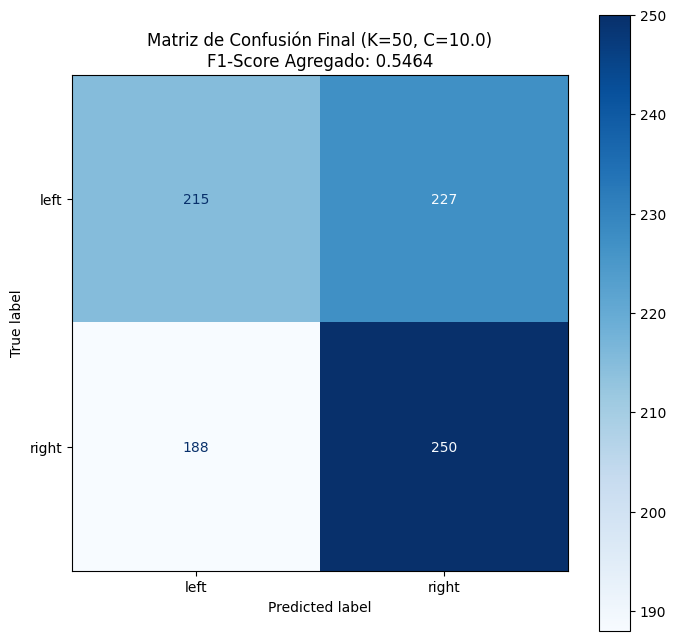

In [16]:
# Celda 8: Reporte de Clasificación y Matriz de Confusión Final

class_names = ['left', 'right']

# --- NUEVO: Reporte de Clasificación ---
# Esto resume Precision, Recall y F1-Score por clase, tal como pedía la imagen
print("--- Reporte de Clasificación Detallado (Agregado) ---")
# Esto usa las variables 'all_y_true' y 'all_y_pred' de la celda anterior
report = classification_report(all_y_true, all_y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Matriz de Confusión ---
print("\n--- Matriz de Confusión (Agregada) ---")
cm = confusion_matrix(all_y_true, all_y_pred)
conf_matrix_final = cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Matriz de Confusión Final (K={BEST_K}, C={BEST_C})\nF1-Score Agregado: {final_f1:.4f}")
plt.show()

In [17]:
# Guardar resultados en results/bof_svm/
print("\n" + "="*70)
print("GUARDANDO RESULTADOS")
print("="*70)

# Guardar grid search results
results_df.to_csv(BOF_RESULTS_DIR / 'grid_search_results.csv', index=False)
print(f"✅ Grid search guardado: {BOF_RESULTS_DIR / 'grid_search_results.csv'}")

# Guardar mejores parámetros
import json
best_params_save = {
    'k_clusters': int(best_params['k_clusters']),
    'svm_c': float(best_params['svm_c']),
    'mean_accuracy': float(best_params['mean_accuracy']),
    'mean_precision': float(best_params['mean_precision']),
    'mean_recall': float(best_params['mean_recall']),
    'mean_f1': float(best_params['mean_f1'])
}

with open(BOF_RESULTS_DIR / 'best_params.json', 'w') as f:
    json.dump(best_params_save, f, indent=2)
print(f"✅ Mejores parámetros guardados: {BOF_RESULTS_DIR / 'best_params.json'}")

# Guardar confusion matrix
np.save(BOF_RESULTS_DIR / 'confusion_matrix.npy', conf_matrix_final)
print(f"✅ Confusion matrix guardada: {BOF_RESULTS_DIR / 'confusion_matrix.npy'}")

# Guardar resumen
with open(BOF_RESULTS_DIR / 'summary.txt', 'w') as f:
    f.write("BAG OF FEATURES + SVM - RESULTADOS\n")
    f.write("="*70 + "\n\n")
    f.write(f"Mejor K: {int(best_params['k_clusters'])}\n")
    f.write(f"Mejor C: {best_params['svm_c']}\n\n")
    f.write(f"Accuracy:  {best_params['mean_accuracy']:.4f}\n")
    f.write(f"Precision: {best_params['mean_precision']:.4f}\n")
    f.write(f"Recall:    {best_params['mean_recall']:.4f}\n")
    f.write(f"F1-Score:  {best_params['mean_f1']:.4f}\n\n")
    f.write(f"Confusion Matrix:\n{conf_matrix_final}\n")

print(f"✅ Resumen guardado: {BOF_RESULTS_DIR / 'summary.txt'}")
print(f"\n📁 Todos los resultados en: {BOF_RESULTS_DIR}")
print("="*70)



GUARDANDO RESULTADOS
✅ Grid search guardado: /Users/manueljurado/Downloads/datos_BCI/results/bof_svm/grid_search_results.csv
✅ Mejores parámetros guardados: /Users/manueljurado/Downloads/datos_BCI/results/bof_svm/best_params.json
✅ Confusion matrix guardada: /Users/manueljurado/Downloads/datos_BCI/results/bof_svm/confusion_matrix.npy
✅ Resumen guardado: /Users/manueljurado/Downloads/datos_BCI/results/bof_svm/summary.txt

📁 Todos los resultados en: /Users/manueljurado/Downloads/datos_BCI/results/bof_svm
